# Final Project - Time Series Analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Part 1 - Introduction

## Data Preprocessing

In [4]:
# Load full data:
original_data = pd.read_csv('data/wind_power_data.csv')
original_data['dt'] = pd.to_datetime(original_data['dt'])
original_data.dropna(inplace=True)
original_data.set_index('dt', inplace=True)
original_data.head()

MW
dt                         
2011-01-01 00:00:00  3416.0
2011-01-01 00:15:00  4755.0
2011-01-01 00:30:00  4939.0
2011-01-01 00:45:00  4939.0
2011-01-01 01:00:00  4998.0

In [5]:
# count null values:
original_data.isnull().sum()

MW    0
dtype: int64

In [6]:
# count if any timestamps in 15 minute intervals are missing:
missing_timestamps = pd.date_range(start=original_data.index.min(), end=original_data.index.max(), freq='15min').difference(original_data.index)

print("missing records: ",len(missing_timestamps))
print("precentage of missing records: ",len(missing_timestamps)/len(original_data.index)*100)

missing records:  52
precentage of missing records:  0.013486666355435904


In [7]:
# get a count of how many missing timestamps per day:
missing_timestamps_per_day = missing_timestamps.floor('D').value_counts().sort_index()
missing_timestamps_per_day

2011-03-27    4
2012-03-25    4
2013-03-31    4
2014-03-30    4
2014-04-07    1
2014-06-20    2
2014-06-25    3
2015-03-29    4
2016-03-27    4
2017-03-26    4
2018-03-25    4
2018-11-26    2
2019-03-31    4
2020-03-29    4
2021-03-28    4
Name: count, dtype: int64

We consider this amount of missing data small enough to be insignificant.

In [157]:
# general info:
original_data.describe()

MW
count  385566.000000
mean     3183.560481
std      3045.941591
min         0.000000
25%       905.000000
50%      2164.000000
75%      4529.877500
max     16727.500000

## Transformation into daily data:

From now on, we will consider the data as daily by summing over the records, since we are interested in a large-scale series analysis.

In [9]:
# sum all values in the same day into one value, and focus on the years 2013-2015:
data = original_data[original_data.index.year <= 2015]
data = data[data.index.year >= 2013]
data = data.resample('D').sum()

rng = pd.date_range(start = '2013-01-01', end = '2015-12-31', freq = 'D')

print("total number of data points: ", len(data))
data.head()

total number of data points:  1095


MW
dt                  
2013-01-01  488985.0
2013-01-02  404620.0
2013-01-03  199476.0
2013-01-04   68686.0
2013-01-05   83074.0

In [10]:
data.describe()

MW
count  1.095000e+03
mean   2.426418e+05
std    2.174237e+05
min    7.770000e+02
25%    8.211400e+04
50%    1.746750e+05
75%    3.230900e+05
max    1.035337e+06

In [12]:
# Save true forecast a year ahead: 
true_forecast = original_data[original_data.index.year == 2016]
true_forecast = true_forecast.resample('D').sum()

forecast_rng = pd.date_range(start = '2016-01-01', end = '2016-12-31', freq = 'D')

print("total number of data points: ", len(true_forecast))
true_forecast.head()

total number of data points:  366


MW
dt                   
2016-01-01   78943.79
2016-01-02  639737.68
2016-01-03  207155.24
2016-01-04   87884.97
2016-01-05  254684.05

In [244]:
true_forecast.describe()

MW
count  3.660000e+02
mean   2.813422e+05
std    2.356835e+05
min    2.109757e+04
25%    1.075076e+05
50%    2.076629e+05
75%    3.633992e+05
max    1.156479e+06

Text(0.5, 1.0, 'Daily Wind Power Production')

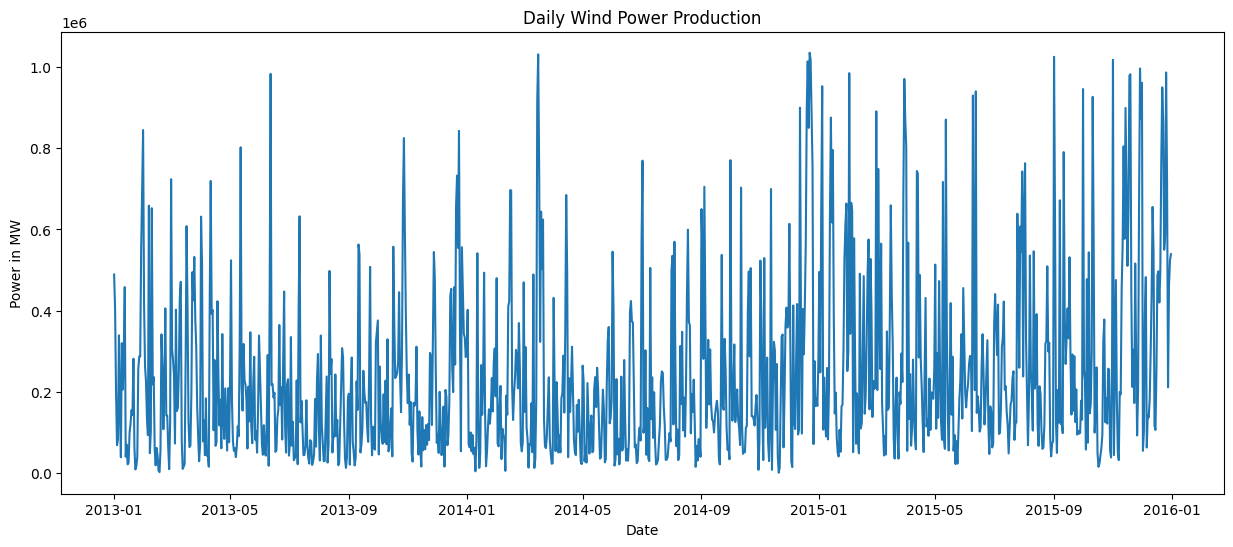

In [7]:
# plot the data:
plt.figure(figsize=(15, 6))
plt.plot(data['MW'], label='Wind Power')
plt.xlabel('Date')
plt.ylabel('Power in MW')
plt.title('Daily Wind Power Production')

## Seasonal Decomposition

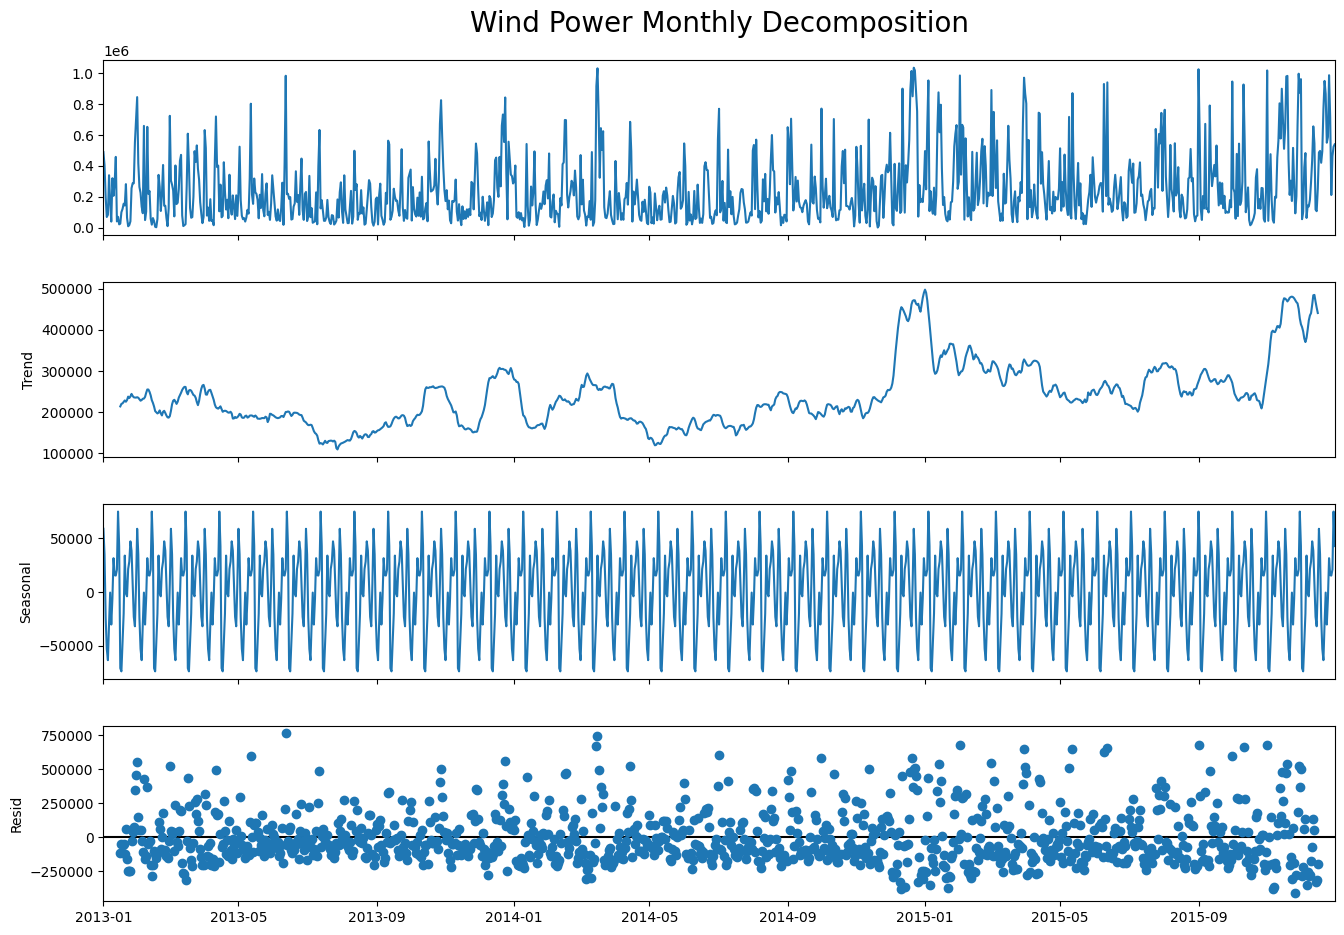

In [8]:
# monthly decomposition:
decomposition = sm.tsa.seasonal_decompose(data['MW'], model='additive', period=30)
fig = decomposition.plot()
fig.axes[0].set_title('Wind Power Monthly Decomposition',fontsize=20, pad=20)
fig.set_size_inches(15, 10)
plt.show()

Since the best decomposition we found has a monthly seasonality, we will assume that the data is monthly seasonal for further modeling.

# Part 2 - Model Fitting

We will attempt to fit a SARIMA model, Prophet, Holt-Winters, and a simple LSTM model to the data.

## SARIMA

Text(0.5, 1.0, 'Wind Power w. Monthly Differencing')

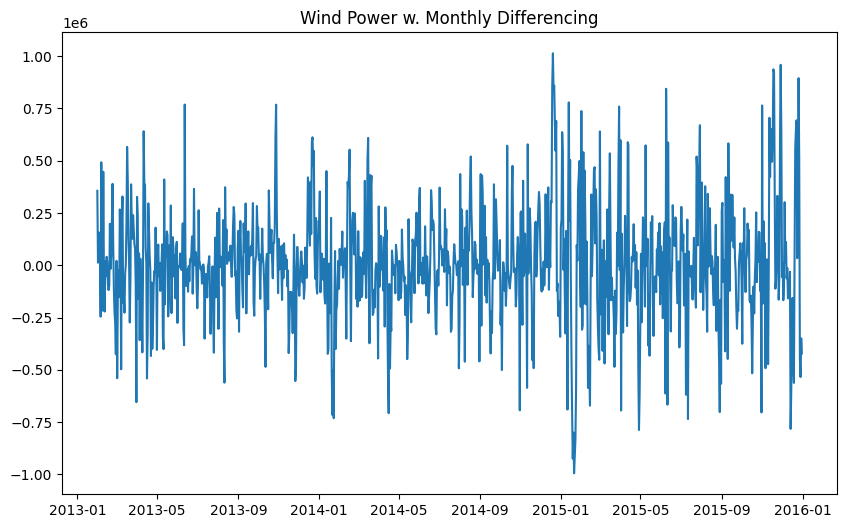

In [245]:
# preform a monthly difference:

data_diff = data.diff(periods=30)
data_diff.dropna(inplace=True)

rng_diff = pd.date_range(start = '2013-01-31', end = '2015-12-31', freq = 'D')

plt.figure(figsize=(10, 6))
plt.plot(data_diff['MW'], label='Wind Power')
plt.title('Wind Power w. Monthly Differencing')

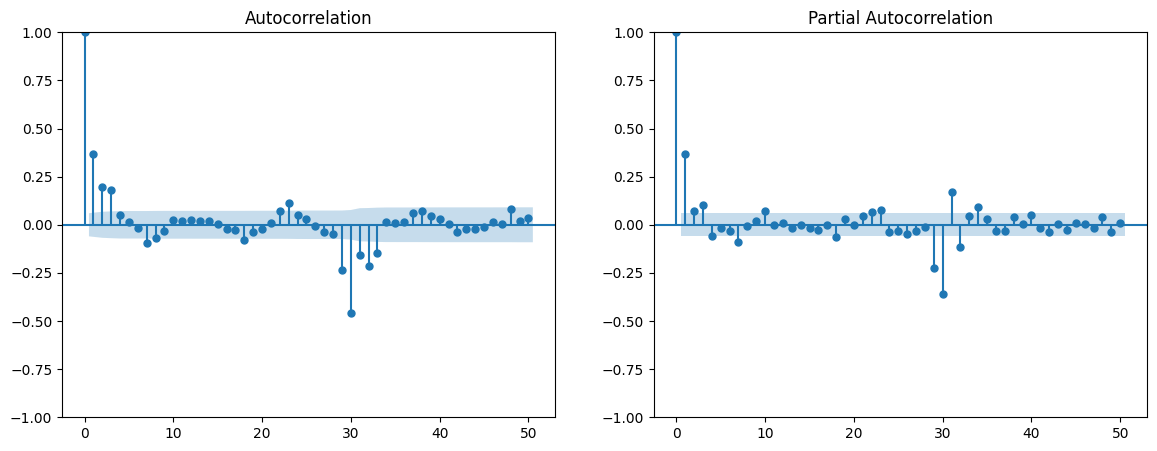

In [250]:
# plot the ACF and PACF:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sm.graphics.tsa.plot_acf(data_diff['MW'], lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(data_diff['MW'], lags=50, ax=ax[1])
plt.show()

Observations:
* The ACF values generally decay to zero, but fluctuate in a pattern which implies additional structure.
* The significant PACF are 1 and 2, and we can also see larger values around 30, specifically 29-32.

Conclusion:
* The differenced series might fit the models: $AR(1)$, $AR(2)$.
* Since we can see additional structure in the ACF, we might need a larger seasonal order.
* Therefore, as seen in class, the transformed stationary series might fit the models: $SARIMA(p, 0, 0)(P, D, Q)_{30} \text{ for combinations of } p \in [1,2], \text{and } P, D, Q \in [0,1,2]$.

We will run a few possible models, including all of the above and some more additional checks for d and q, to find the best one by the BIC metric:

In [ ]:
# We will try multiple models and compare them using AIC and BIC:

best_bic = np.inf # pick model with lowest BIC
best_model = None

for p,d,q,P,D,Q in [(p,d,q,P,D,Q) for p in [1,2] for d in [0,1] for q in [0,1] for P in [0,1,2] for D in [0,1,2] for Q in [0,1,2]]:
    model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, 30))
    model_fit = model.fit(disp=False)
    print(f"model: SARIMA({p},{d},{q})({P},{D},{Q})30", "AIC:", model_fit.aic, "BIC:", model_fit.bic, "Log Likelihood:", model_fit.llf)

    if model_fit.bic < best_bic: 
        best_bic = model_fit.bic
        best_model = model_fit

# best model found using this method: (1,0,0)(0,2,2)30

In [252]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# try to improve upon best model by initializing to model found and find best sarima automatically:
sarima_model = auto_arima(data['MW'], start_p=1, start_q=0, start_P=0, start_Q=2, D=2,
                          stationarity=False, seasonality=True, m=30, stepwise=True, nmodels=100, 
                          trace=True, approximation=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,2,2)[30]             : AIC=inf, Time=57.37 sec
 ARIMA(0,0,0)(0,2,0)[30]             : AIC=29978.310, Time=0.76 sec
 ARIMA(1,0,0)(1,2,0)[30]             : AIC=29385.186, Time=17.23 sec
 ARIMA(0,0,1)(0,2,1)[30]             : AIC=inf, Time=22.62 sec
 ARIMA(1,0,0)(0,2,0)[30]             : AIC=29811.972, Time=1.46 sec
 ARIMA(1,0,0)(2,2,0)[30]             : AIC=29256.080, Time=30.79 sec
 ARIMA(1,0,0)(2,2,1)[30]             : AIC=inf, Time=49.72 sec
 ARIMA(1,0,0)(1,2,1)[30]             : AIC=inf, Time=43.71 sec
 ARIMA(0,0,0)(2,2,0)[30]             : AIC=29133.447, Time=27.74 sec
 ARIMA(0,0,0)(1,2,0)[30]             : AIC=29349.309, Time=11.54 sec
 ARIMA(0,0,0)(2,2,1)[30]             : AIC=inf, Time=41.72 sec
 ARIMA(0,0,0)(1,2,1)[30]             : AIC=inf, Time=19.58 sec
 ARIMA(0,0,1)(2,2,0)[30]             : AIC=29294.658, Time=26.78 sec
 ARIMA(1,0,1)(2,2,0)[30]             : AIC=29250.174, Time=49.31 sec
 ARIMA(0,0,0)(2,2,0)[30] inte

We note we tried multiple approaches to finding the best model, inclusing running auto_arima without start parameters and for a longer time, but couldn't beat the (1,0,0)(0,2,2)30 model.

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


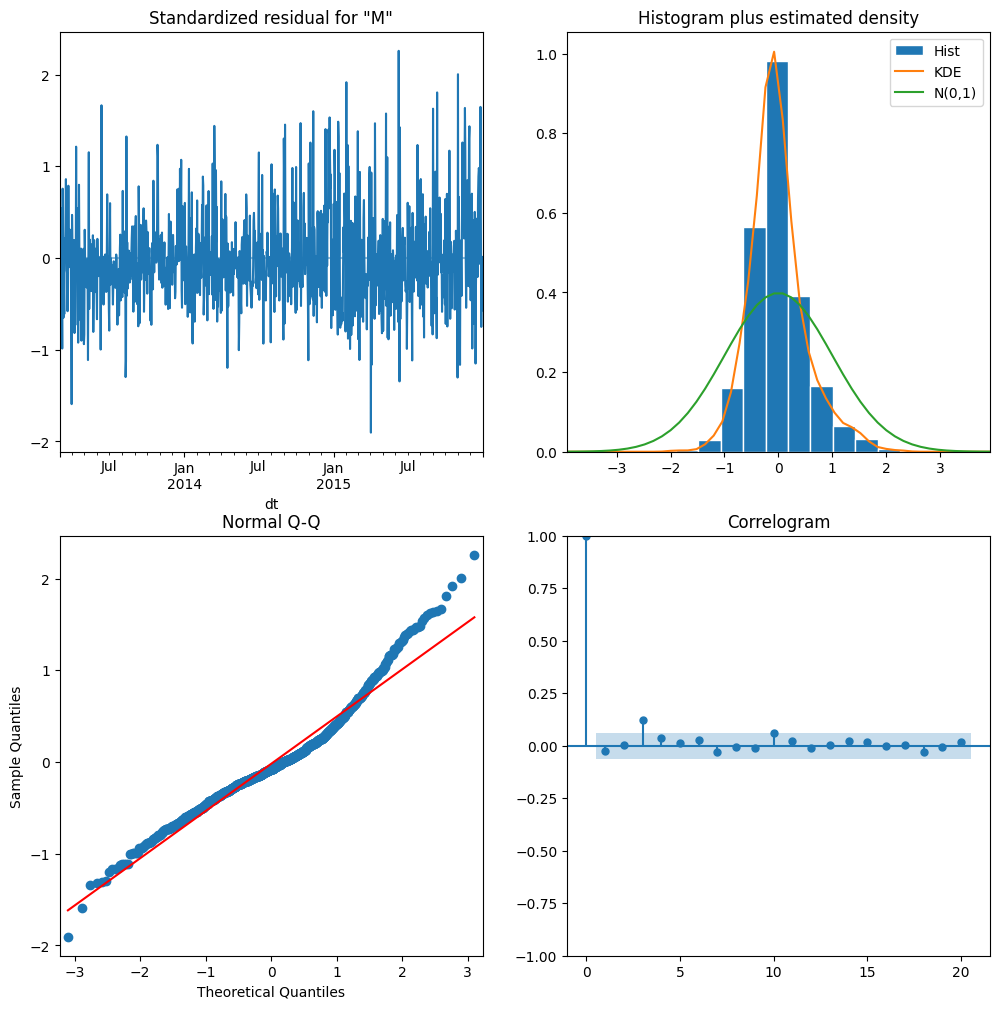

In [31]:
best_model = SARIMAX(data, order=(1, 0, 0), seasonal_order=(0, 2, 2, 30))
model_fit = best_model.fit(disp=False)

# Using the plot_diagnostics method:
model_fit.plot_diagnostics(lags=20,figsize=(12, 12))
plt.show()

In [261]:
print(model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                      MW   No. Observations:                 1095
Model:             SARIMAX(1, 0, 0)x(0, 2, [1, 2], 30)   Log Likelihood              -14545.729
Date:                                 Thu, 09 May 2024   AIC                          29099.457
Time:                                         04:47:28   BIC                          29119.226
Sample:                                     01-01-2013   HQIC                         29106.958
                                          - 12-31-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4006      0.082      4.909      0.000       0.241       0

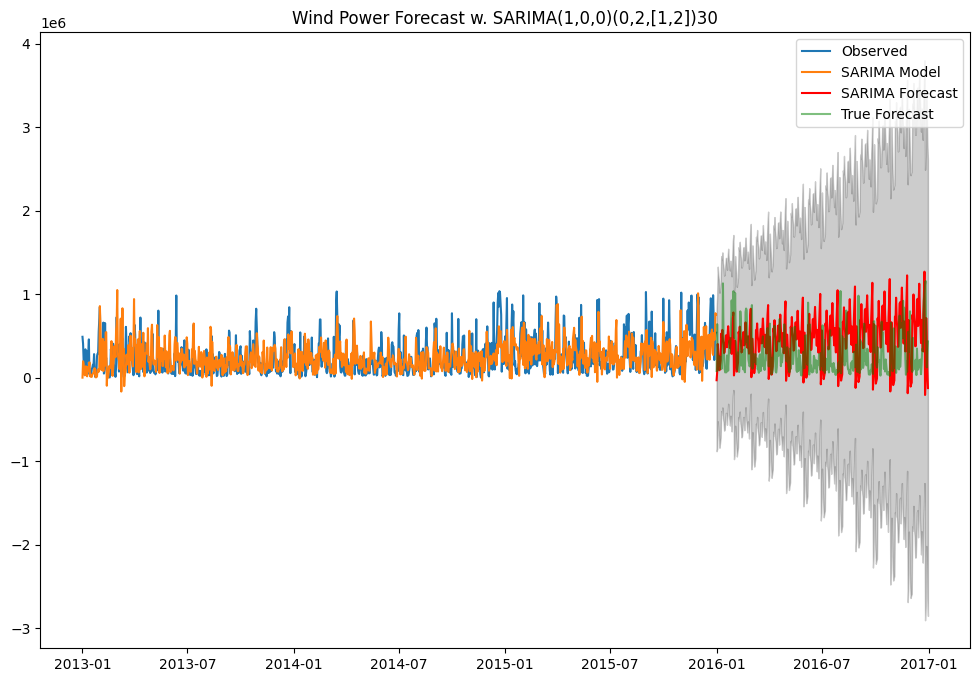

In [32]:
# predict the next year:
sarima_forecast = model_fit.get_forecast(steps=366)
sarima_forecast_ci = sarima_forecast.conf_int()

plt.figure(figsize=(12, 8))

plt.plot(data['MW'], label='Observed')
plt.plot(model_fit.fittedvalues, label='SARIMA Model', color='#ff7f0e')

plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='k', alpha=0.2)
plt.plot(true_forecast['MW'], label='True Forecast', alpha=0.5, color='green')

plt.title('Wind Power Forecast w. SARIMA(1,0,0)(0,2,[1,2])30')
plt.legend()
plt.show()

## Prophet

14:14:15 - cmdstanpy - INFO - Chain [1] start processing
14:14:15 - cmdstanpy - INFO - Chain [1] done processing


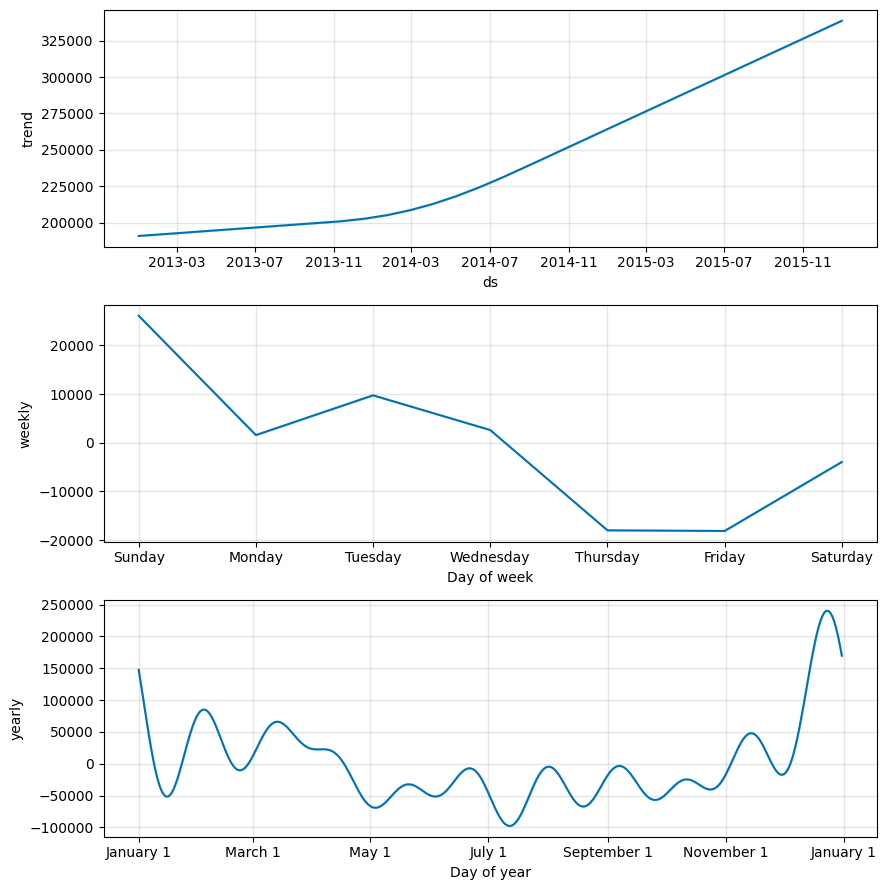

In [33]:
# fit model to the data using prophet:
data_prophet = data.reset_index()
data_prophet.columns = ['ds', 'y']
model_prophet = Prophet()

# fit the model:
model_prophet.fit(data_prophet)

# evaluate the model parameters:
model_prophet.plot_components(model_prophet.predict(data_prophet))
plt.show()

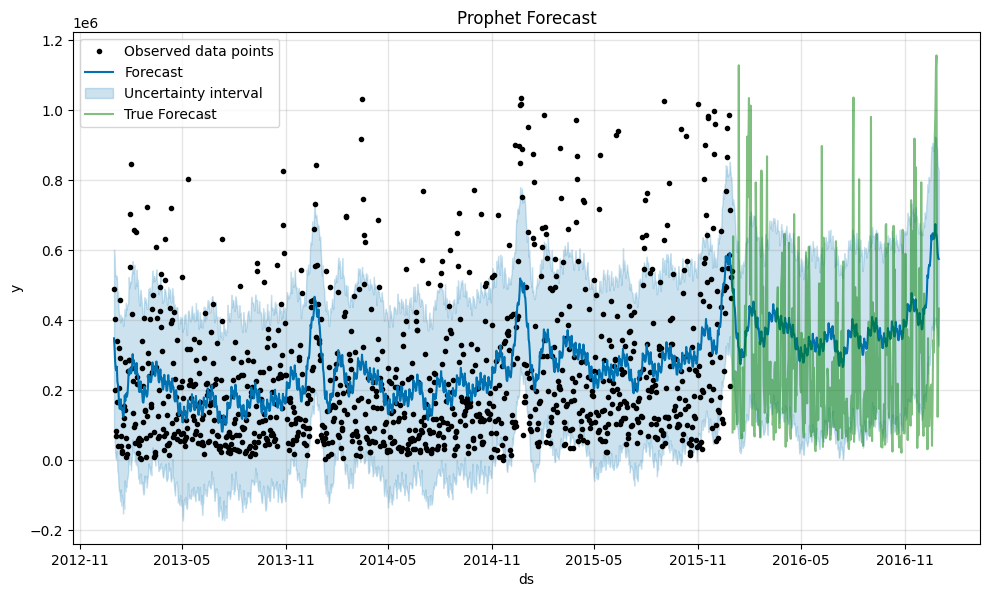

In [40]:
# forecast:
future = model_prophet.make_future_dataframe(periods=366)
prophet_forecast = model_prophet.predict(future)

model_prophet.plot(prophet_forecast)
plt.plot(true_forecast['MW'], label='True Forecast', alpha=0.5, color='green')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

## Prophet w. Holiday Effects

14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:54 - cmdstanpy - INFO - Chain [1] done processing


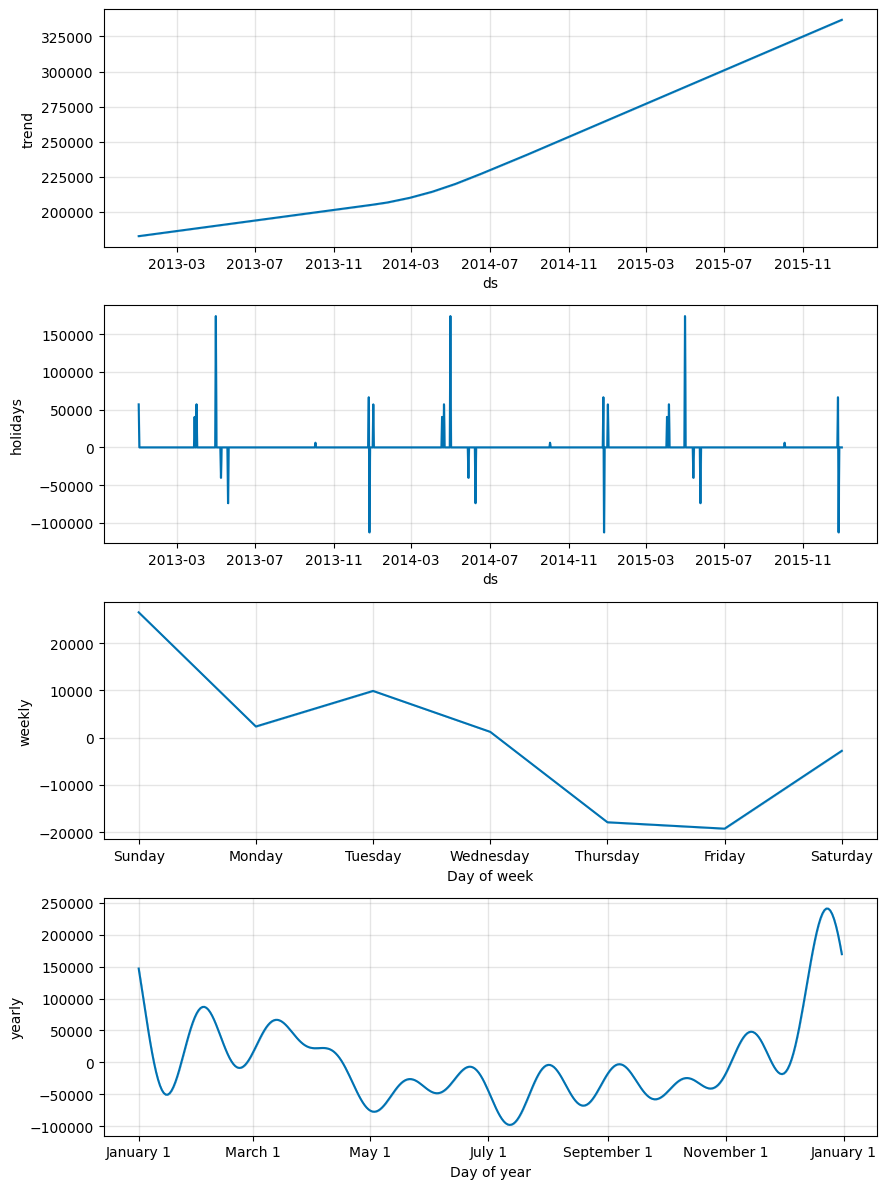

In [42]:
model_prophet_hol = Prophet()

# add german holidays (since the data is from a wind farm in Germany):
model_prophet_hol.add_country_holidays(country_name='DE')

# fit the model:
model_prophet_hol.fit(data_prophet)

# evaluate the model parameters:
model_prophet_hol.plot_components(model_prophet_hol.predict(data_prophet))
plt.show()

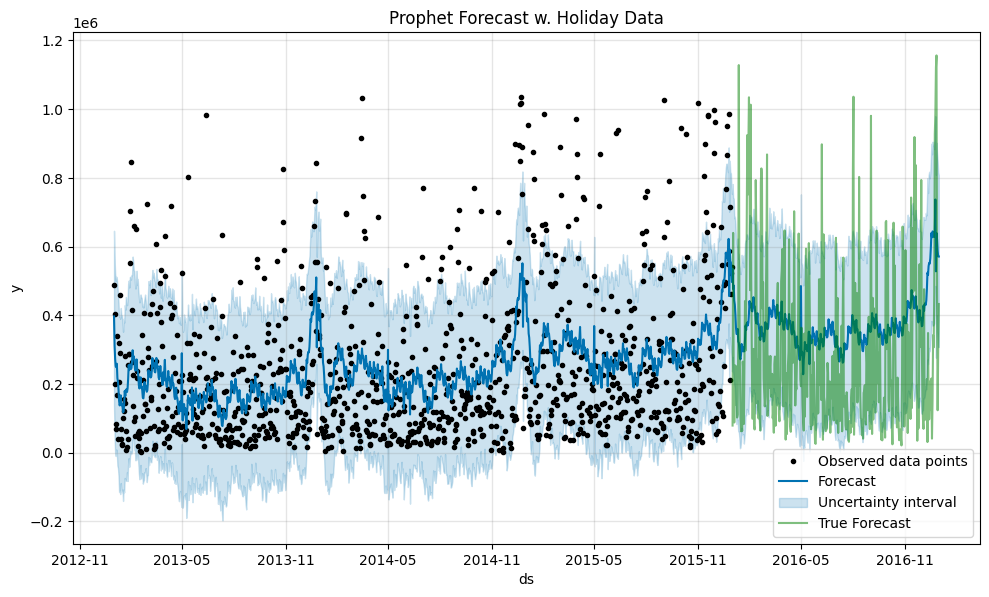

In [43]:
# forecast:
future_hol = model_prophet_hol.make_future_dataframe(periods=366)
prophet_hol_forecast = model_prophet_hol.predict(future_hol)

model_prophet_hol.plot(prophet_hol_forecast)
plt.plot(true_forecast['MW'], label='True Forecast', alpha=0.5, color='green')
plt.title('Prophet Forecast w. Holiday Data')
plt.legend()
plt.show()

We notice a slight difference between the models with and without holiday effects.

## Exponential Smoothing

In [37]:
SES = ExponentialSmoothing(data, seasonal_periods=30, seasonal='add', trend='add', damped_trend=True)
ses_fit = SES.fit()

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [264]:
ses_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                       MW   No. Observations:                 1095
Model:             ExponentialSmoothing   SSE                 48396926750423.367
Optimized:                         True   AIC                          26910.583
Trend:                         Additive   BIC                          27085.531
Seasonal:                      Additive   AICC                         26913.243
Seasonal Periods:                    30   Date:                 Thu, 09 May 2024
Box-Cox:                          False   Time:                         05:06:31
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1817857                alpha                 True
smoothing_trend                  0.0001                 beta                 True
smoothing_seasonal            0.0944093                gamma                 True
initial_level                2.1361e+05                  l.0                 True
initial_trend                 2453.3903                  b.0                 True
damping_trend                 0.9900000                  phi                 True
initial_seasons.0            2.8009e+05                  s.0                 True
initial_seasons.1            2.1012e+05                  s.1                 True
initial_seasons.2            -34663.471                  s.2                 True
initial_seasons.3            -97719.138                  s.3                 True
initial_seasons.4            -64697.225                  s.4                 True
initial_seasons.5            -1.006e+05                  s.5                 True
initial_seasons.6             1399.4496                  s.6                 True
initial_seasons.7           -1.2219e+05                  s.7                 True
initial_seasons.8            -59703.017                  s.8                 True
initial_seasons.9            1.8487e+05                  s.9                 True
initial_seasons.10           1.0572e+05                 s.10                 True
initial_seasons.11           1.3283e+05                 s.11                 True
initial_seasons.12           -53096.030                 s.12                 True
initial_seasons.13          -1.4771e+05                 s.13                 True
initial_seasons.14            12559.820                 s.14                 True
initial_seasons.15           -33906.525                 s.15                 True
initial_seasons.16           -72330.421                 s.16                 True
initial_seasons.17           -51050.992                 s.17                 True
initial_seasons.18           -92480.950                 s.18                 True
initial_seasons.19           -51788.084                 s.19                 True
initial_seasons.20            13562.320                 s.20                 True
initial_seasons.21           -34519.134                 s.21                 True
initial_seasons.22            31206.120                 s.22                 True
initial_seasons.23            56528.779                 s.23                 True
initial_seasons.24           -51917.130                 s.24                 True
initial_seasons.25            15551.250                 s.25                 True
initial_seasons.26           -52524.371                 s.26                 True
initial_seasons.27          -1.0684e+05                 s.27                 True
initial_seasons.28            10246.962                 s.28                 True
initial_seasons.29        

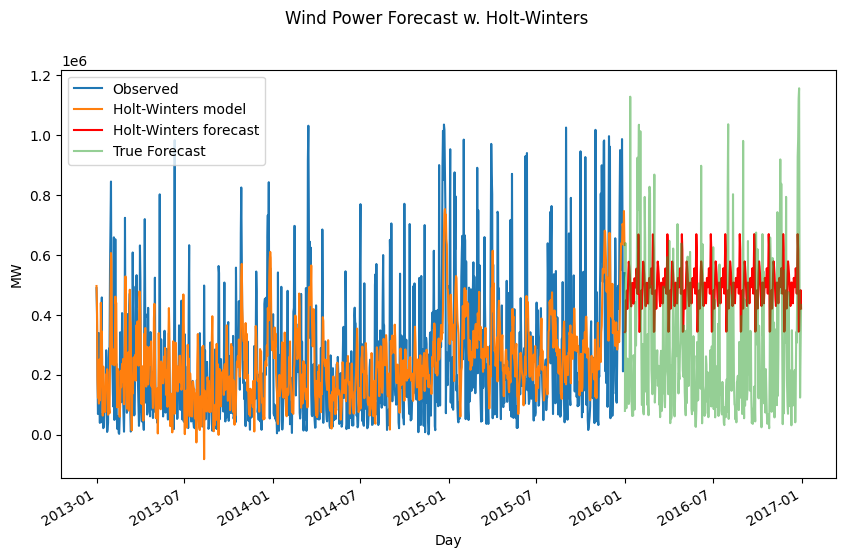

In [326]:
fig,ax = plt.subplots(figsize=(10, 6))
ax.plot(rng, data, label="Observed") 
ses_fit.fittedvalues.plot(label="Holt-Winters model")

ses_fit.forecast(366).plot(label="Holt-Winters forecast", color='red')
plt.plot(forecast_rng, true_forecast['MW'], label='True Forecast', alpha=0.5)

ax.set_xlabel("Day", fontsize=10)
ax.set_ylabel("MW", fontsize=10)
ax.legend(fontsize=10)
fig.suptitle("Wind Power Forecast w. Holt-Winters")
plt.show()

## LSTM

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

# set seed for tensorflow:
from numpy.random import seed
import tensorflow as tf

seed(42)
tf.random.set_seed(42)

In [15]:
from sklearn.preprocessing import MinMaxScaler

train_data_lstm = data.copy()
test_data_lstm = true_forecast.copy()

train_size = int(len(train_data_lstm))
y_train = train_data_lstm['MW']
y_test = test_data_lstm['MW']

y_train = y_train.values.reshape((-1, 1))
y_test = y_test.values.reshape((-1, 1))

# Since the data is of a large scale, we will normalize it using MinMaxScaler to avoid overflow:
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# forecast a value based on the last 'lookbck' days:
lookback = 90
batch_size = 16

In [16]:
train_generator = TimeseriesGenerator(y_train, y_train, length=lookback, batch_size=batch_size)
test_generator = TimeseriesGenerator(y_test, y_test, length=lookback, batch_size=batch_size)

In [17]:
# Define an LSTM model:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')
# model.fit(train_generator, epochs=100, verbose=1, validation_data=test_generator, callbacks=[early_stopping])

model.fit(train_generator, epochs=50, verbose=1)

Epoch 1/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - loss: 0.1944

/opt/homebrew/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0598
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0421
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0382
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0379
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0394
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0397
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0374
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0367
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0428
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0363
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0363
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0481
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0373
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0418
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0318
Epoch 16/50
63/

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


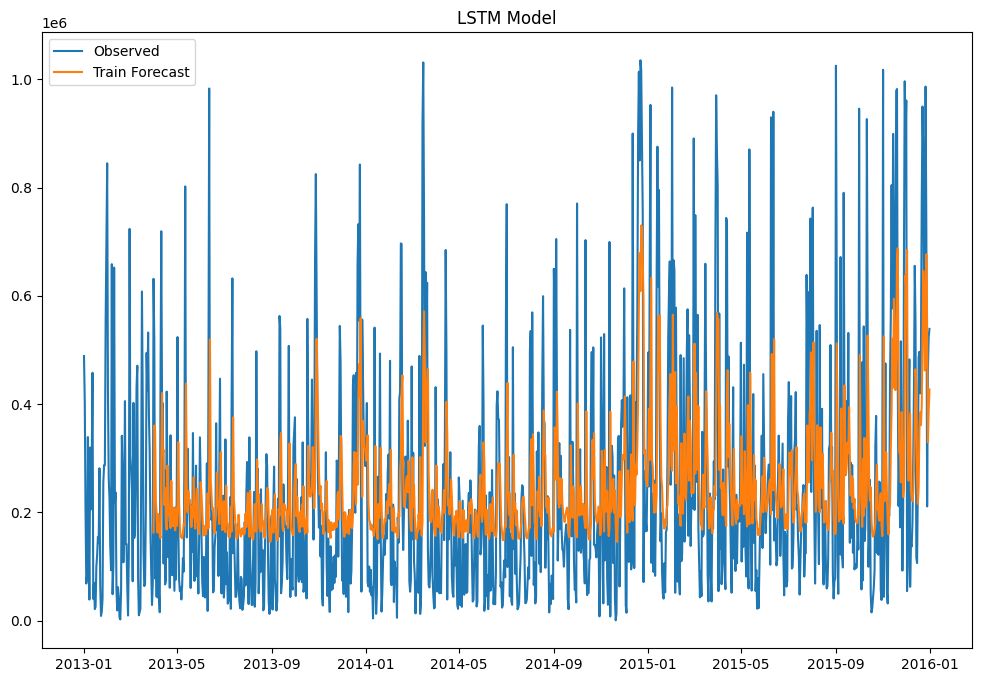

In [371]:
# Plot the model on the train data (by predicting the train data with the model):
plt.figure(figsize=(12, 8))
plt.plot(data['MW'], label='Observed')
plt.plot(train_rng, scaler.inverse_transform(model.predict(train_generator)), label='Train Forecast') # inverse transform to get the original scale
plt.title('LSTM Model')
plt.legend()
plt.show()

### Forecast w. Self-Input

For a fair comparison with the rest of the models, we don't want to use the future values as input for the LSTM model. Therefore, we will use the models own predictions as input for the next prediction.

In [19]:
# forecast a year ahead using the LSTM model:
x_input = y_train[-lookback:]
predictions = []

for i in range(366):  # Forecast for a year ahead
    x_input_reshaped = x_input.reshape((1, lookback, 1))
    yhat = model.predict(x_input_reshaped, verbose=0)
    predictions.append(yhat[0, 0])
    # Move the window of x_input and insert the prediction at the end:
    x_input = np.append(x_input[1:], yhat[0, 0])

# Prepare forecast DataFrame for plotting:
forecast_dates = pd.date_range(start='2016-01-01', end='2016-12-31', freq='D')
lstm_forecast_df = pd.DataFrame(predictions, index=forecast_dates, columns=['Forecast'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


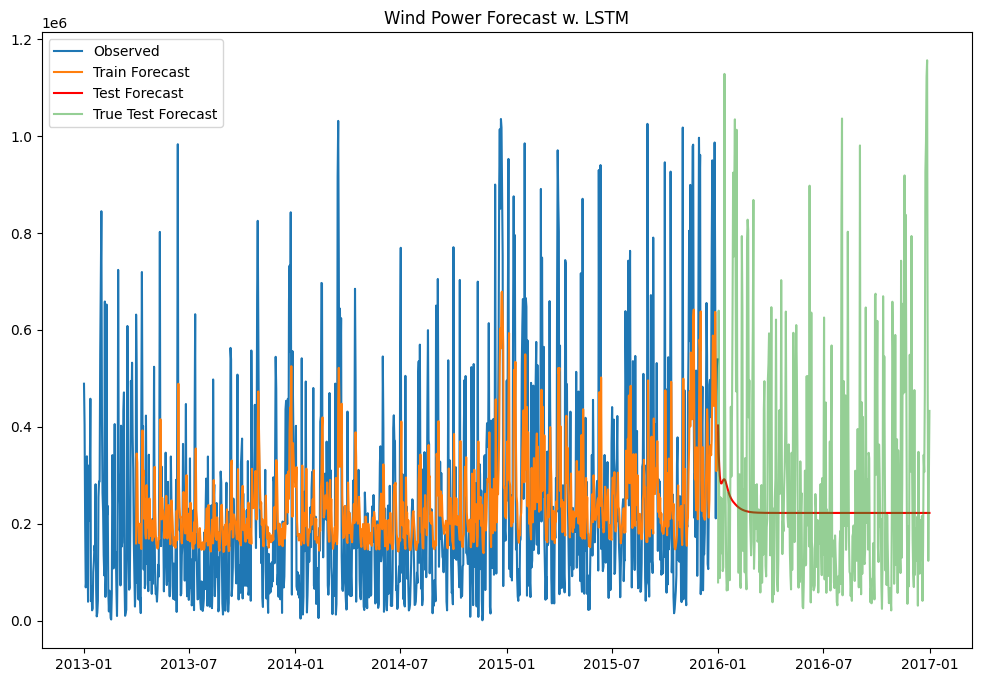

RMSE of LSTM forecast: 241413.05392446302


In [20]:
# inverse transform to get the original scale:
predictions_transformed = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
lstm_forecast_trans_df = pd.DataFrame(predictions_transformed, index=forecast_dates, columns=['Forecast'])
train_rng = pd.date_range(start='2013-01-01', end='2015-12-31', freq='D')[lookback:]

# plot the forecast:
plt.figure(figsize=(12, 8))
plt.plot(data['MW'], label='Observed')
plt.plot(train_rng, scaler.inverse_transform(model.predict(train_generator)), label='Train Forecast')
plt.plot(lstm_forecast_trans_df, label='Test Forecast', color='red')
plt.plot(true_forecast['MW'], label='True Test Forecast', alpha=0.5)
plt.title('Wind Power Forecast w. LSTM')
plt.legend()
plt.show()

# rmse:
lstm_rmse = np.sqrt(mean_squared_error(true_forecast['MW'], lstm_forecast_trans_df['Forecast']))
print(f"RMSE of LSTM forecast: {lstm_rmse}")

In [159]:
print("mean of true forecast: ", true_forecast['MW'].mean())
print("mean of LSTM forecast: ", lstm_forecast_trans_df['Forecast'].mean())
print("mode of lstm forecast: ", lstm_forecast_trans_df['Forecast'].median())

mean of true forecast:  281342.23844262294
mean of LSTM forecast:  246725.81
mode of lstm forecast:  237629.28


Notice that once the model is relying on it's own predictions, it converges to a near-constant value close to the mean of the data.

### Forecast w. Forced True Input - One Ahead

To solve this problem, we will examine how well our model predicts when a true value is fed back into the model one step ahead.

In [26]:
# predict lstm only one day ahead (feed true data):
x_input = y_train[-lookback:]
oneahead_predictions = []

for i in range(366):  # Forecast for a year ahead
    x_input_reshaped = x_input.reshape((1, lookback, 1))
    yhat = model.predict(x_input_reshaped, verbose=0)
    oneahead_predictions.append(yhat[0][0])
    # Move the window of x_input and insert the true value at the end:
    norm_true_value = scaler.transform(np.array(true_forecast['MW'][i]).reshape(-1, 1)) # normalize the true value
    x_input = np.append(x_input[1:], norm_true_value)

# Prepare forecast DataFrame for plotting
lstm_oneahead_forecast_df = pd.DataFrame(oneahead_predictions, index=forecast_dates, columns=['Forecast'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


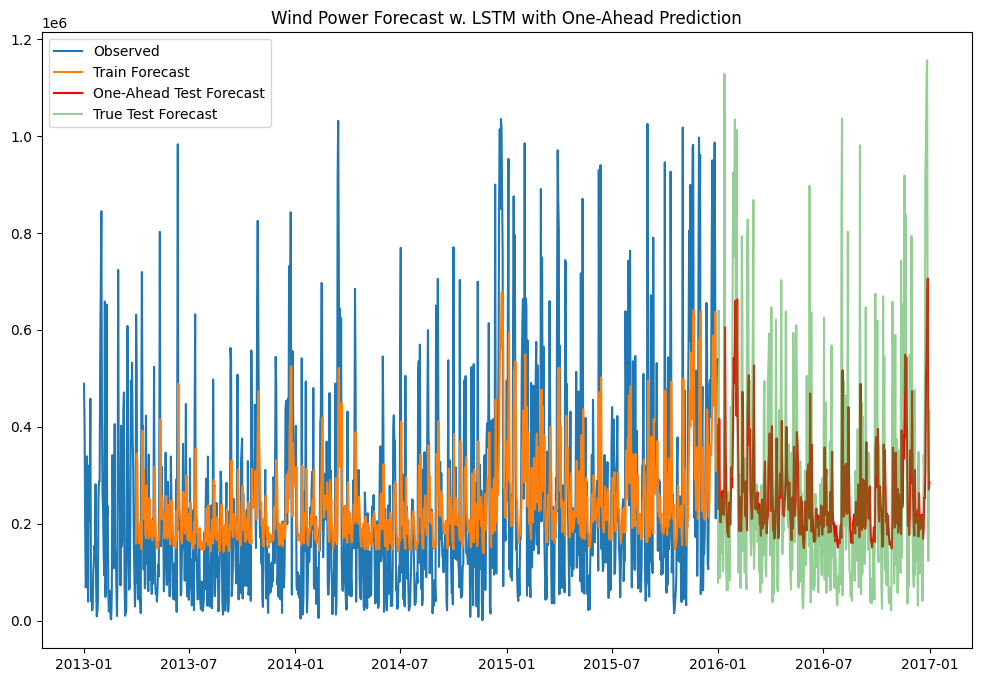

RMSE of LSTM forecast with one ahead: 213050.88422233704


In [29]:
oneahead_predictions_transformed = scaler.inverse_transform(np.array(oneahead_predictions).reshape(-1, 1)) # inverse transform to get the original scale
oneahead_lstm_forecast_trans_df = pd.DataFrame(oneahead_predictions_transformed, index=forecast_dates, columns=['Forecast'])
train_rng = pd.date_range(start='2013-01-01', end='2015-12-31', freq='D')[lookback:]

# plot the forecast:
plt.figure(figsize=(12, 8))
plt.plot(data['MW'], label='Observed')
plt.plot(train_rng, scaler.inverse_transform(model.predict(train_generator)), label='Train Forecast')
plt.plot(oneahead_lstm_forecast_trans_df, label='One-Ahead Test Forecast', color='red')
plt.plot(true_forecast['MW'], label='True Test Forecast', alpha=0.5)
plt.title('Wind Power Forecast w. LSTM with One-Ahead Prediction')
plt.legend()
plt.show()

# rmse:
lstm_oneahead_rmse = np.sqrt(mean_squared_error(true_forecast['MW'], oneahead_lstm_forecast_trans_df['Forecast']))
print(f"RMSE of LSTM forecast with one ahead: {lstm_oneahead_rmse}")

As expected, this model preforms better.

## Evaluate & Compare Results

we will use the RMSE metric on predictions a year ahead to compare the models.


In [44]:
# move prophet forecast to start at the same date as the true forecast:
prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])
prophet_forecast.set_index('ds', inplace=True)
prophet_forecast = prophet_forecast[prophet_forecast.index >= '2016-01-01']

# move prophet forecast to start at the same date as the true forecast:
prophet_hol_forecast['ds'] = pd.to_datetime(prophet_hol_forecast['ds'])
prophet_hol_forecast.set_index('ds', inplace=True)
prophet_hol_forecast = prophet_hol_forecast[prophet_hol_forecast.index >= '2016-01-01']

/var/folders/b1/6p4sk8f166d1j8xr27c9vfxm0000gp/T/ipykernel_6128/3278312589.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', 6)  # Generate 5 colors from the viridis colormap


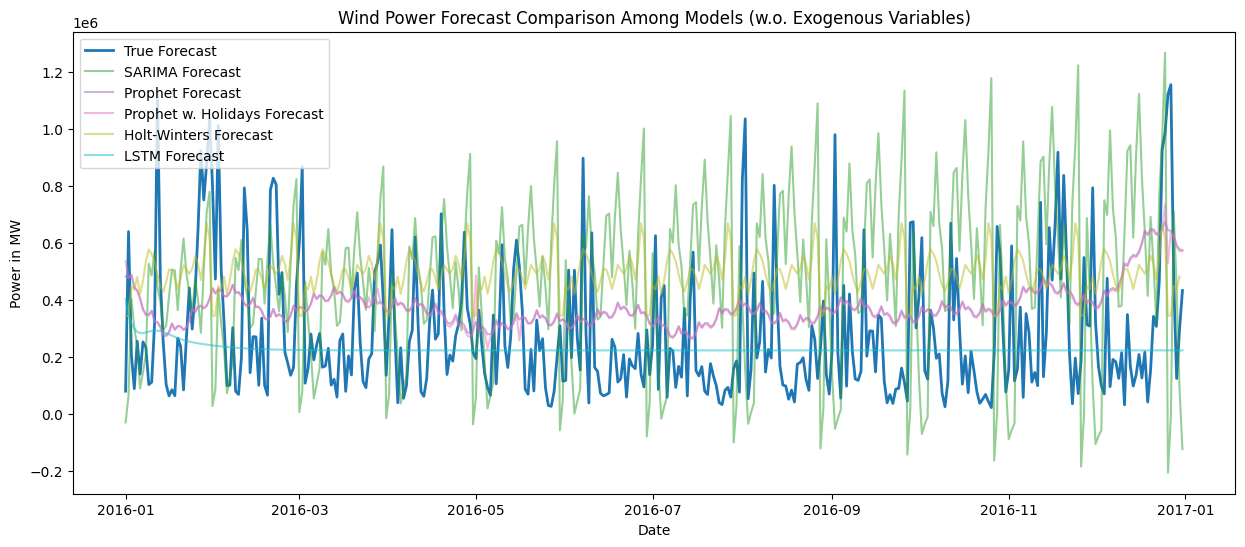

In [45]:
import matplotlib.cm as cm

# plot all forecasts next to true forecast:
plt.figure(figsize=(15, 6))

# Define a color palette
cmap = cm.get_cmap('tab10', 6)  # Generate 5 colors from the viridis colormap
palette = [cmap(i) for i in range(cmap.N)]

# Plot each forecast with a different color from the palette
sns.lineplot(data=true_forecast['MW'], label='True Forecast', linewidth=2, color=palette[0])
sns.lineplot(data=sarima_forecast.predicted_mean, label='SARIMA Forecast', alpha=0.5, color=palette[1])
sns.lineplot(data=prophet_forecast['yhat'], label='Prophet Forecast', alpha=0.5, color=palette[2])
sns.lineplot(data=prophet_hol_forecast['yhat'], label='Prophet w. Holidays Forecast', alpha=0.5, color=palette[3])
sns.lineplot(data=ses_fit.forecast(365), label='Holt-Winters Forecast', alpha=0.5, color=palette[4])
sns.lineplot(data=lstm_forecast_trans_df['Forecast'], label='LSTM Forecast', alpha=0.5, color=palette[5])

plt.xlabel('Date')
plt.ylabel('Power in MW')
plt.title('Wind Power Forecast Comparison Among Models (w.o. Exogenous Variables)')
plt.legend()
plt.show()

In [46]:
# compare RMSE metrics in a table:

sarima_rmse = mean_squared_error(true_forecast['MW'], sarima_forecast.predicted_mean, squared=False)
prophet_rmse = mean_squared_error(true_forecast['MW'], prophet_forecast['yhat'], squared=False)
prophet_hol_rmse = mean_squared_error(true_forecast['MW'], prophet_hol_forecast['yhat'], squared=False)
ses_rmse = mean_squared_error(true_forecast['MW'], ses_fit.forecast(366), squared=False)

rmse_table = pd.DataFrame({'Model': ['SARIMA', 'Prophet', 'Prophet w. Holidays', 'Holt-Winters', 'LSTM'], 'RMSE': [sarima_rmse, prophet_rmse, prophet_hol_rmse, ses_rmse, lstm_rmse]})
rmse_table

Model           RMSE
0               SARIMA  430256.689423
1              Prophet  251773.985603
2  Prophet w. Holidays  251658.544146
3         Holt-Winters  326736.260692
4                 LSTM  241413.053924

Note we do not compare the One-Ahead LSTM model to the rest, as it is not a fair comparison.

Among these basic models, the LSTM seems best with Prophet w. holidays as a close second.

# Part 3 - Incorporating an Exogenous Variable

Our variable is the daily average wind speed from a power station in germany. However, the location of the weather station does not necessary match the location of the power plant.

In [287]:
# combine the data of the necessary years:

# weather_2013 = pd.read_csv('data/raw_data/weather_2013.csv', delimiter=';')
# weather_2013['Datum'] = pd.to_datetime(weather_2013['Datum'], format='%d.%m.%Y')
# weather_2013.set_index('Datum', inplace=True)
# weather_2013 = weather_2013[['Wmit']]

# weather_2014 = pd.read_csv('data/raw_data/weather_2014.csv', delimiter=';')
# weather_2014['Datum'] = pd.to_datetime(weather_2014['Datum'], format='%d.%m.%Y')
# weather_2014.set_index('Datum', inplace=True)
# weather_2014 = weather_2014[['Wmit']]

# weather_2015 = pd.read_csv('data/raw_data/weather_2015.csv', delimiter=';')
# weather_2015['Datum'] = pd.to_datetime(weather_2015['Datum'], format='%d.%m.%Y')
# weather_2015.set_index('Datum', inplace=True)
# weather_2015 = weather_2015[['Wmit']]

# weather_2016 = pd.read_csv('data/raw_data/weather_2016.csv', delimiter=';')
# weather_2016['Datum'] = pd.to_datetime(weather_2016['Datum'], format='%d.%m.%Y')
# weather_2016.set_index('Datum', inplace=True)
# weather_2016 = weather_2016[['Wmit']]

# weather_data = pd.concat([weather_2013, weather_2014, weather_2015, weather_2016])
# weather_data.columns = ['Wind_Speed']

# print("total number of data points: ", len(weather_data))
# weather_data.head()


total number of data points:  1461


Wind_Speed
Datum                 
2013-01-01          15
2013-01-02          13
2013-01-03          14
2013-01-04          13
2013-01-05           9

In [268]:
# save this new data:
# weather_data.to_csv('data/exogenous_var_data.csv')

In [49]:
# read data:
weather_data = pd.read_csv('data/exogenous_var_data.csv')
weather_data['Datum'] = pd.to_datetime(weather_data['Datum'])
weather_data.set_index('Datum', inplace=True)

weather_data.describe()

Wind_Speed
count  1461.000000
mean     10.668036
std       3.932478
min       2.000000
25%       8.000000
50%      10.000000
75%      13.000000
max      27.000000

In [50]:
weather_train = weather_data[weather_data.index.year <= 2015]
weather_test = weather_data[weather_data.index.year == 2016]

print('train:', len(weather_train), 'test:', len(weather_test))

train: 1095 test: 366


In [51]:
from scipy.stats import pearsonr

data_weather = data.join(weather_data)
corr, pval = pearsonr(data_weather['MW'], data_weather['Wind_Speed'])

print('Pearsons correlation: %.3f' % corr)
print('p_value:', pval)

Pearsons correlation: 0.287
p_value: 3.6550772068263283e-22


### Linear Regression

In [86]:
# combine the wind power data with the weather data by date:
data_exog = data.copy()
data_exog['Wind_Speed'] = weather_train['Wind_Speed']
data_exog.dropna(inplace=True)

# combine the wind power data with the weather data by date:
true_forecast_exog = true_forecast.copy()
true_forecast_exog['Wind_Speed'] = weather_test['Wind_Speed']
true_forecast_exog.dropna(inplace=True)

data_exog.head()


MW  Wind_Speed
dt                              
2013-01-01  488985.0          15
2013-01-02  404620.0          13
2013-01-03  199476.0          14
2013-01-04   68686.0          13
2013-01-05   83074.0           9

In [44]:
# normalize the data:
norm_data_exog = (data_exog - data_exog.mean()) / data_exog.std()
norm_data_exog.head()

MW  Wind_Speed
dt                              
2013-01-01  1.133010    1.132606
2013-01-02  0.744989    0.627019
2013-01-03 -0.198533    0.879813
2013-01-04 -0.800077    0.627019
2013-01-05 -0.733902   -0.384153

In [86]:
# linear regression model:
X = norm_data_exog[['Wind_Speed']]
y = norm_data_exog['MW']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MW   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     97.89
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           3.66e-22
Time:                        22:50:19   Log-Likelihood:                -1506.3
No. Observations:                1095   AIC:                             3017.
Df Residuals:                    1093   BIC:                             3027.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.851e-17      0.029   9.84e-16      1.000      -0.057       0.057
Wind_Speed     0.2867      0.029      9.894      0.000       0.230       0.344
==============================================================================
Omnibus:                      254.166   Durbin-Watson:                   1.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.480
Skew:                           1.365   Prob(JB):                    1.89e-107
Kurtosis:                       4.822   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

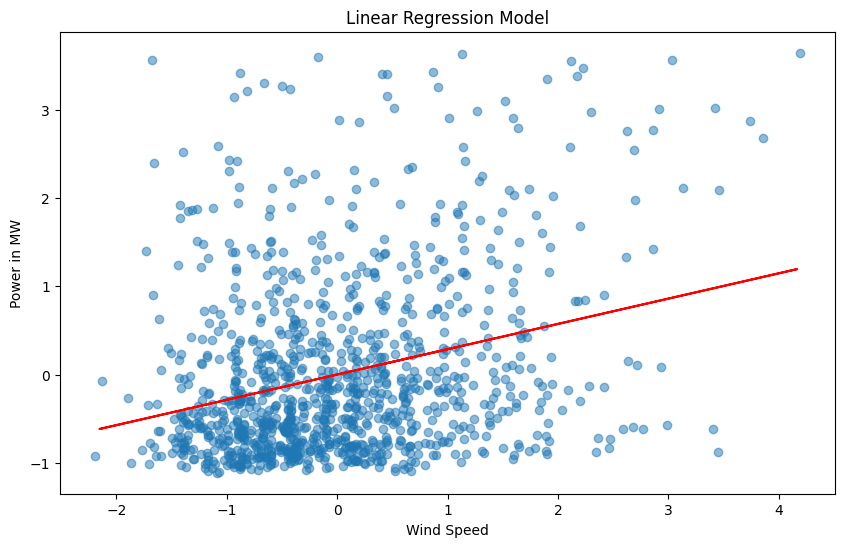

In [90]:
# random variable from normal distribution:
np.random.seed(42)
random_x = np.random.normal(0, 0.07, len(data_exog)) # add small noise to the x values for clearer visualization:

# plot the linear regression model:
plt.figure(figsize=(10, 6))
plt.scatter(norm_data_exog['Wind_Speed'] + random_x, norm_data_exog['MW'], alpha=0.5)
plt.plot(norm_data_exog['Wind_Speed'], model.predict(X), color='red')
plt.xlabel('Wind Speed')
plt.ylabel('Power in MW')
plt.title('Linear Regression Model')
plt.show()

## SARIMA w. Exogenous Variable

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


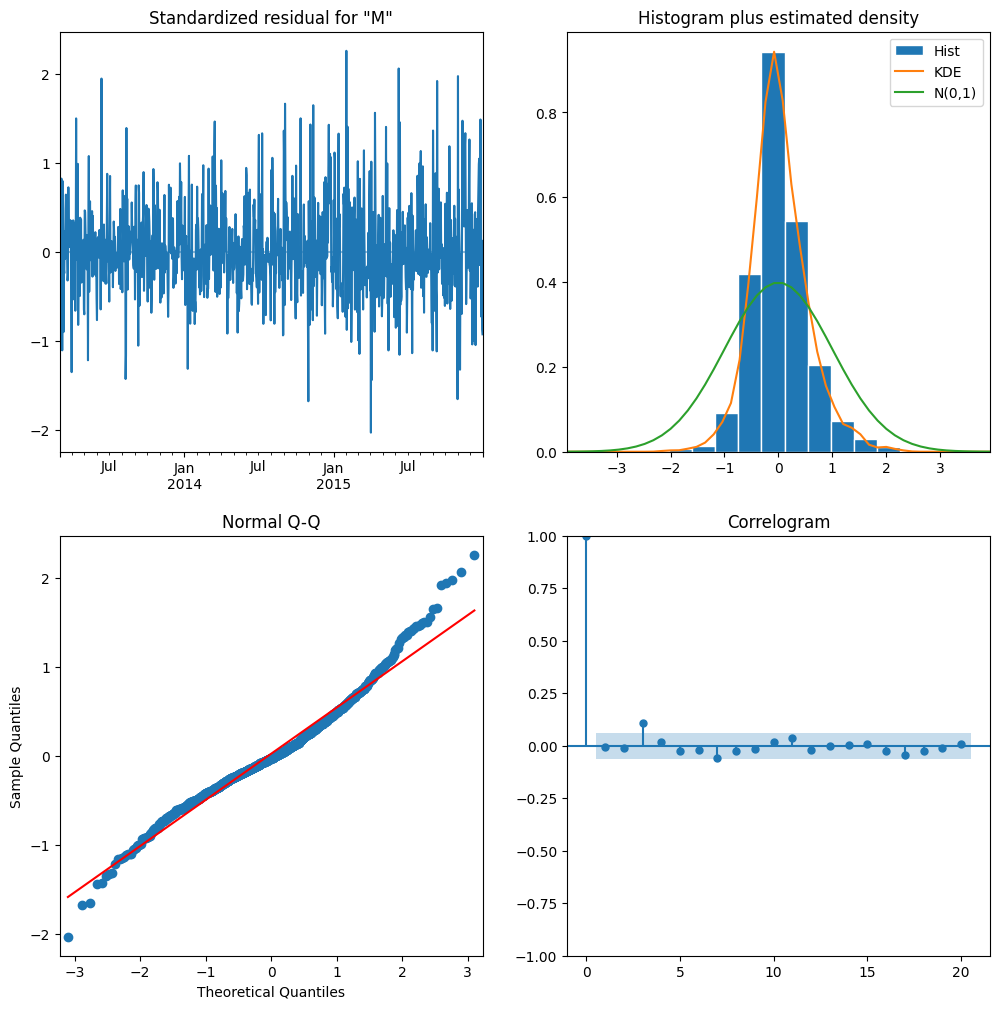

In [327]:
# sarima model:
exg_sarima_model = SARIMAX(data, order=(1, 0, 0), seasonal_order=(0, 2, 2, 30), exog=weather_train)
exg_sarima_model_fit = exg_sarima_model.fit(disp=False)

exg_sarima_model_fit.plot_diagnostics(lags=20,figsize=(12, 12))
plt.show()


In [329]:
exg_sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                      MW   No. Observations:                 1095
Model:             SARIMAX(1, 0, 0)x(0, 2, [1, 2], 30)   Log Likelihood              -14498.934
Date:                                 Thu, 09 May 2024   AIC                          29007.868
Time:                                         11:13:03   BIC                          29032.579
Sample:                                     01-01-2013   HQIC                         29017.245
                                          - 12-31-2015                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Wind_Speed  2.321e+04   5364.059      4.327      0.000    1.27e+04    3.37e+04
ar.L1          0.2603      0.090      2.906      0.004       0.085       0.436
ma.S.L30      -1.5522      0.084    -18.585      0.000      -1.716      -1.388
ma.S.L60       0.6121      0.093      6.585      0.000       0.430       0.794
sigma2      1.715e+11   5.82e-05   2.95e+15      0.000    1.71e+11    1.71e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               136.30
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.93e+31. Standard errors may be unstable.
"""

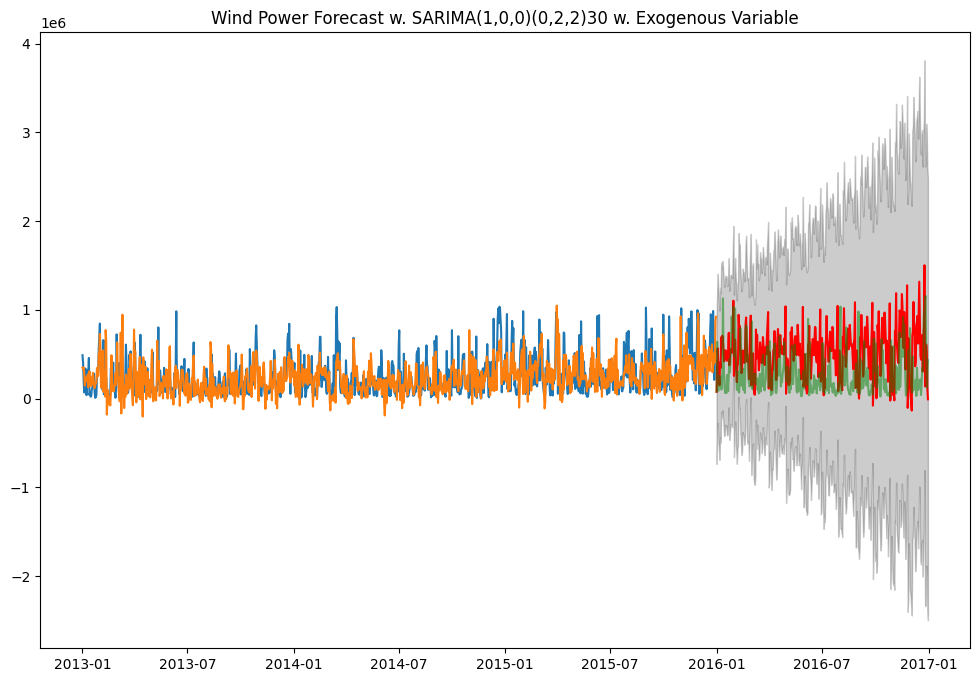

In [328]:
# plot:
exg_sarima_forecast = exg_sarima_model_fit.get_forecast(steps=366, exog=weather_test)
exg_sarima_forecast_ci = exg_sarima_forecast.conf_int()

plt.figure(figsize=(12, 8))
plt.plot(data['MW'], label='Observed')
plt.plot(exg_sarima_model_fit.fittedvalues, label='SARIMA Model', color='#ff7f0e')

plt.plot(exg_sarima_forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(exg_sarima_forecast_ci.index, exg_sarima_forecast_ci.iloc[:, 0], exg_sarima_forecast_ci.iloc[:, 1], color='k', alpha=0.2)
plt.plot(true_forecast['MW'], label='True Forecast', alpha=0.5, color='green')

plt.title('Wind Power Forecast w. SARIMA(1,0,0)(0,2,2)30 w. Exogenous Variable')
plt.show()

In [18]:
# calculate RMSE:
exg_sarima_rmse = mean_squared_error(true_forecast['MW'], exg_sarima_forecast.predicted_mean, squared=False)
exg_sarima_rmse

420226.398485219

## Prophet w. Exogenous Variable

14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing


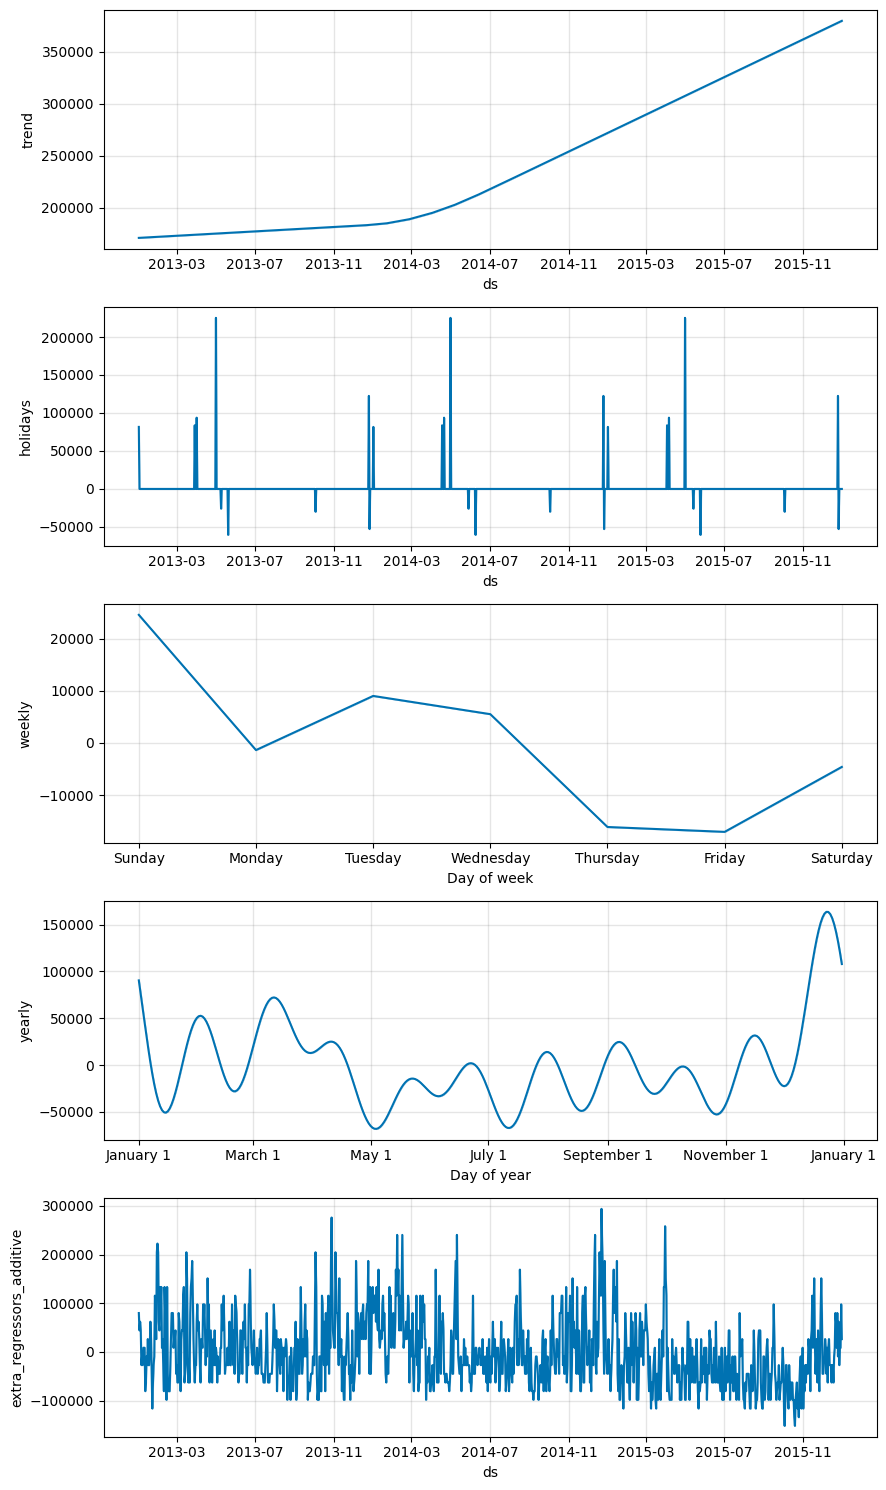

In [54]:
data_exog_prophet = data_exog.reset_index()
data_exog_prophet.columns = ['ds', 'y', 'Wind_Speed']

model_prophet_exog = Prophet()

# add the exogenous variable:
model_prophet_exog.add_regressor('Wind_Speed')

# add german holidays:
model_prophet_exog.add_country_holidays(country_name='DE')

# fit the model:
model_prophet_exog.fit(data_exog_prophet)

# evaluate the model parameters:
model_prophet_exog.plot_components(model_prophet_exog.predict(data_exog_prophet))
plt.show()

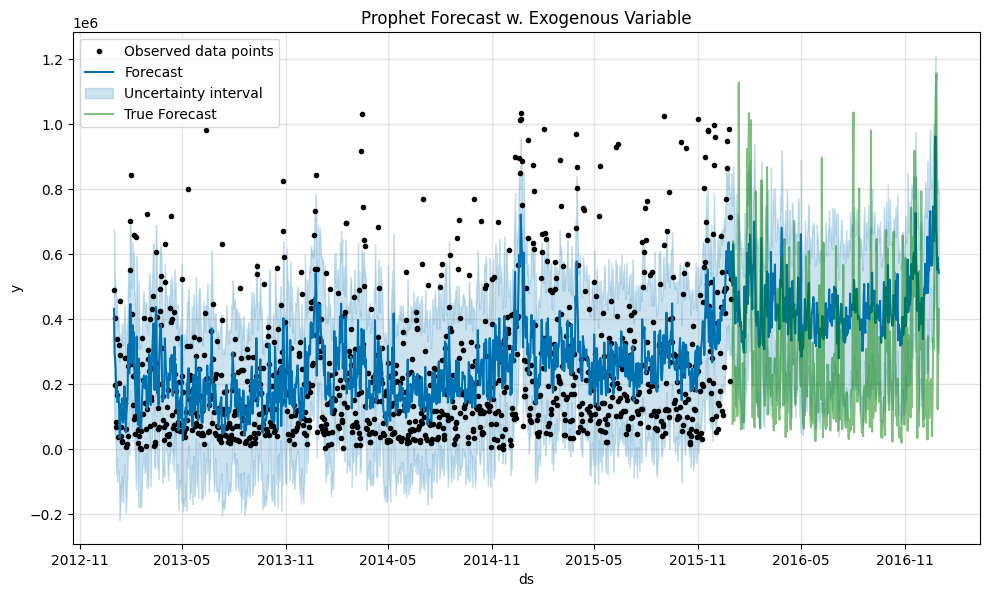

In [55]:
# forecast for all data points:
test_exog_prophet = weather_data.reset_index()
test_exog_prophet.columns = ['ds', 'Wind_Speed']

predict = model_prophet_exog.predict(test_exog_prophet)
model_prophet_exog.plot(predict)
plt.plot(true_forecast_exog['MW'], label='True Forecast', alpha=0.5, color='green')
plt.title('Prophet Forecast w. Exogenous Variable')
plt.legend()
plt.show()


In [56]:
# forecast for all data points:
test_exog_prophet = weather_test.reset_index()
test_exog_prophet.columns = ['ds', 'Wind_Speed']
predict_test = model_prophet_exog.predict(test_exog_prophet)

# RMSE for the exogenous variable model:
prophet_exog_rmse = mean_squared_error(true_forecast_exog['MW'].index.year, predict_test['yhat'], squared=False)
prophet_exog_rmse

453538.61796557374

## LSTM w. Exogenous Variable

In [93]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, concatenate, Input
from tensorflow.keras.models import Model

In [120]:
# Prepare the combined dataset for LSTM:

train_data_lstm = data_exog.copy()  # Your existing dataset
test_data_lstm = true_forecast_exog.copy()  # Your forecasting dataset

exog_train = train_data_lstm['Wind_Speed'].values.reshape((-1, 1))
exog_test = test_data_lstm['Wind_Speed'].values.reshape((-1, 1))
y_train = train_data_lstm['MW'].values.reshape((-1, 1))
y_test = test_data_lstm['MW'].values.reshape((-1, 1))

# Scale the target and exogenous variables:
scaler_y = MinMaxScaler()
scaler_exog = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
exog_train_scaled = scaler_exog.fit_transform(exog_train)
exog_test_scaled = scaler_exog.transform(exog_test)

# create dfs with index:
train_df = pd.concat([pd.DataFrame(y_train_scaled, index=train_data_lstm.index, columns=['MW']), pd.DataFrame(exog_train_scaled, index=train_data_lstm.index, columns=['Wind_Speed'])], axis=1)
test_df = pd.concat([pd.DataFrame(y_test_scaled, index=test_data_lstm.index, columns=['MW']), pd.DataFrame(exog_test_scaled, index=test_data_lstm.index, columns=['Wind_Speed'])], axis=1)

train_X = train_df.values
test_X = test_df.values
train_y = train_df['MW'].values
test_y = test_df['MW'].values

# Generate data sequences for LSTM
lookback = 90
batch_size = 16

train_generator_exog = TimeseriesGenerator(train_X, train_y, length=lookback, batch_size=batch_size)
test_generator_exog = TimeseriesGenerator(test_X, test_y, length=lookback, batch_size=batch_size)

In [121]:
# LSTM Model
model_exog = Sequential()
model_exog.add(LSTM(150, input_shape=(lookback, 2)))
model_exog.add(Dense(1))
model_exog.compile(optimizer='adam', loss='mse')


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [124]:
model_exog.fit(train_generator, epochs=50, verbose=1)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0478
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0365
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0443
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0302
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0354
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0358
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0315
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0384
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0342
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0317
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0301
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0363
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0394
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0371
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0340
Epoc

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


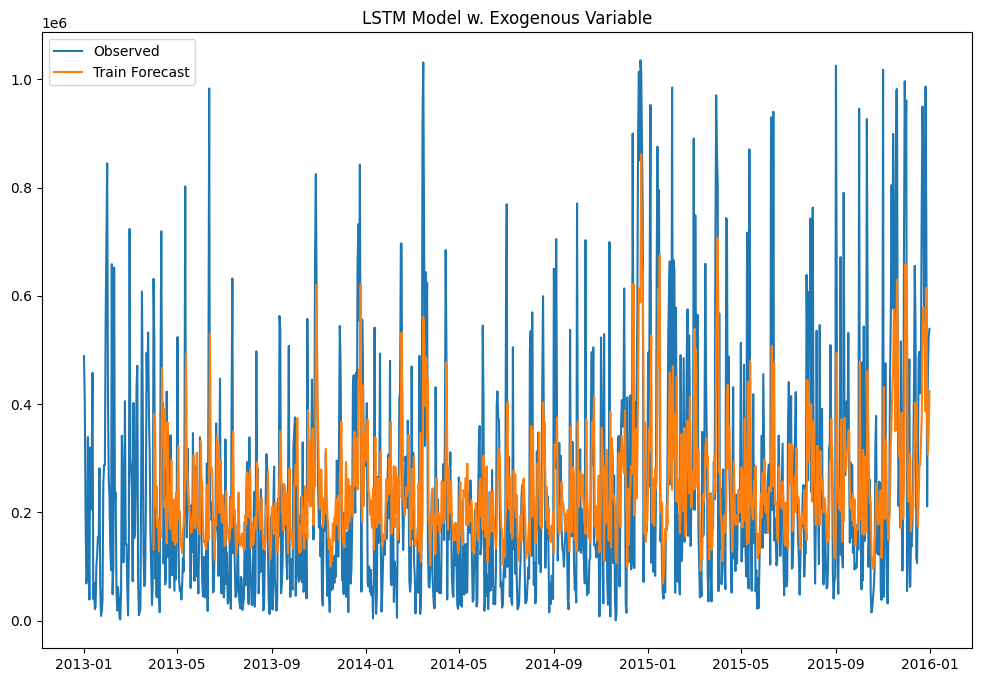

In [127]:
# Plot the model on the train data (by predicting the train data with the model):
plt.figure(figsize=(12, 8))
plt.plot(data['MW'], label='Observed')
plt.plot(train_rng, scaler_y.inverse_transform(model_exog.predict(train_generator_exog)), label='Train Forecast')
plt.title('LSTM Model w. Exogenous Variable')
plt.legend()
plt.show()

### Forecast with self-input

In [141]:
# forecast a year ahead using the LSTM model:
x_input = train_X[-lookback:]
predictions = []

for i in range(366):  # Forecast for a year ahead
    x_input_reshaped = x_input.reshape((1, lookback, 2))
    yhat = model_exog.predict(x_input_reshaped, verbose=0)
    predictions.append(yhat[0, 0])
    # Move the window of x_input and insert the prediction at the end
    x_input = np.append(x_input[1:], np.array([yhat[0, 0], exog_test_scaled[i][0]])).reshape(-1, 2)

# Prepare forecast DataFrame for plotting
forecast_dates = pd.date_range(start='2016-01-01', end='2016-12-31', freq='D')
lstm_forecast_df = pd.DataFrame(predictions, index=forecast_dates, columns=['Forecast'])

predictions_transformed = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


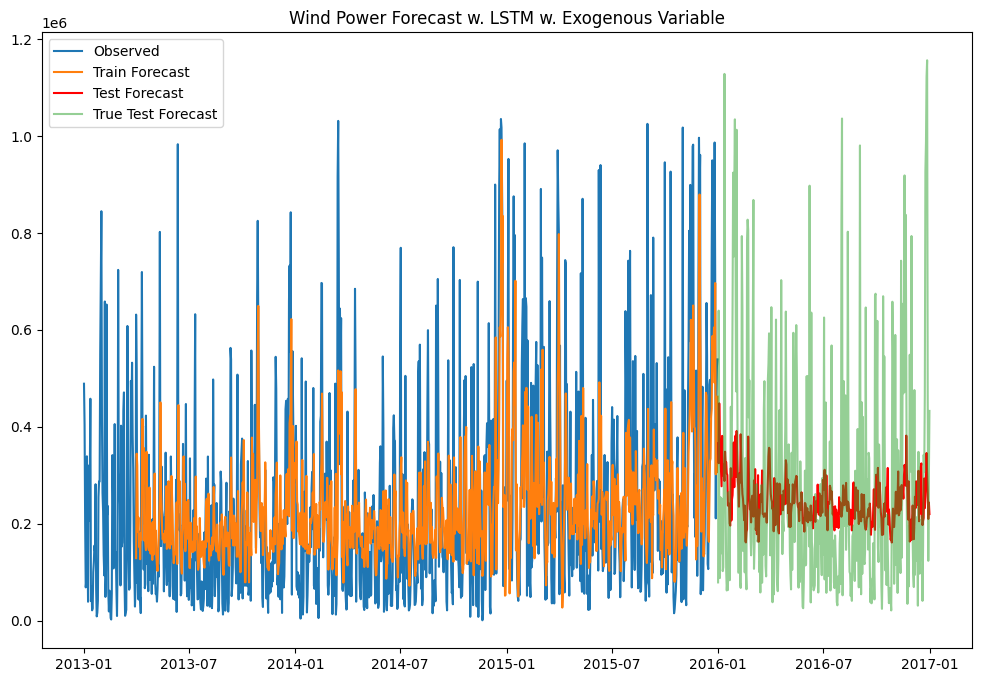

RMSE of LSTM forecast: 229313.25740821217


In [142]:
lstm_forecast_trans_df = pd.DataFrame(predictions_transformed, index=forecast_dates, columns=['Forecast'])
train_rng = pd.date_range(start='2013-01-01', end='2015-12-31', freq='D')[lookback:]

# plot the forecast:
plt.figure(figsize=(12, 8))
plt.plot(data['MW'], label='Observed')
plt.plot(train_rng, scaler.inverse_transform(model.predict(train_generator)), label='Train Forecast')
plt.plot(lstm_forecast_trans_df, label='Test Forecast', color='red')
plt.plot(true_forecast['MW'], label='True Test Forecast', alpha=0.5)
plt.title('Wind Power Forecast w. LSTM w. Exogenous Variable')
plt.legend()
plt.show()

# rmse:
lstm_rmse_exog = np.sqrt(mean_squared_error(true_forecast['MW'], lstm_forecast_trans_df['Forecast']))
print(f"RMSE of LSTM forecast: {lstm_rmse_exog}")

### Forecast w. Forced True Input - One Ahead

In [149]:
# predict lstm only one day ahead (feed true data):
x_input = train_X[-lookback:]
oneahead_predictions = []

for i in range(366):  # Forecast for a year ahead
    x_input_reshaped = x_input.reshape((1, lookback, 2))
    yhat = model_exog.predict(x_input_reshaped, verbose=0)
    oneahead_predictions.append(yhat[0][0])
    # Move the window of x_input and insert the true value at the end:
    norm_true_value = scaler.transform(np.array(true_forecast['MW'][i]).reshape(-1, 1))[0][0]
    x_input = np.append(x_input[1:], np.array([norm_true_value, exog_test_scaled[i][0]])).reshape(-1, 2)

# Prepare forecast DataFrame for plotting
lstm_oneahead_forecast_df = pd.DataFrame(oneahead_predictions, index=forecast_dates, columns=['Forecast'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


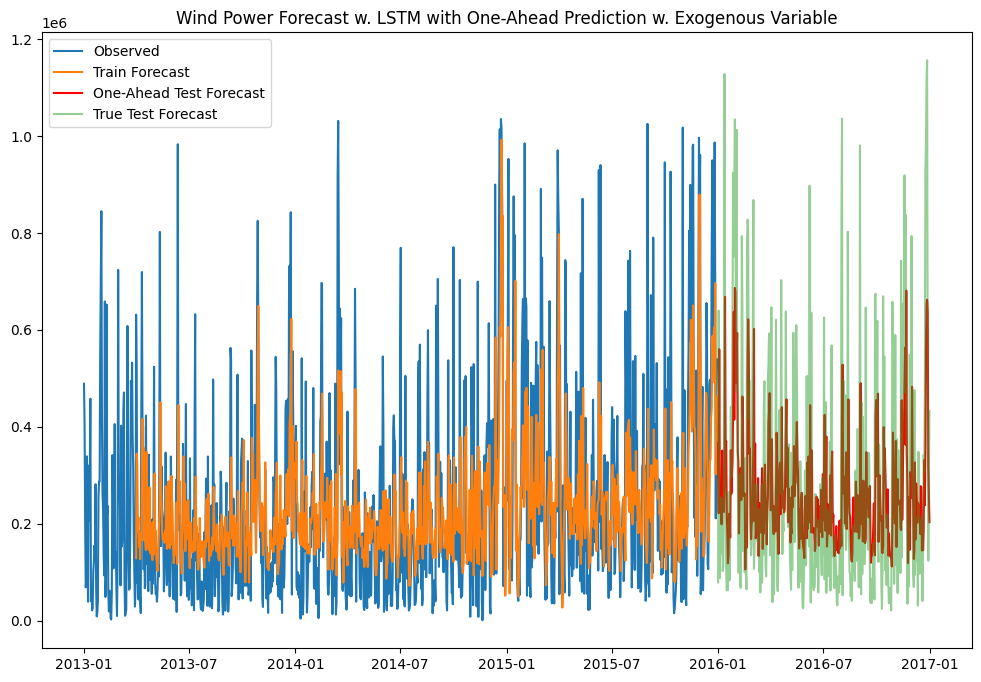

RMSE of LSTM forecast with one ahead: 209771.5233058404


In [150]:
oneahead_predictions_transformed = scaler.inverse_transform(np.array(oneahead_predictions).reshape(-1, 1))
oneahead_lstm_forecast_trans_df = pd.DataFrame(oneahead_predictions_transformed, index=forecast_dates, columns=['Forecast'])
train_rng = pd.date_range(start='2013-01-01', end='2015-12-31', freq='D')[lookback:]

# plot the forecast:
plt.figure(figsize=(12, 8))
plt.plot(data['MW'], label='Observed')
plt.plot(train_rng, scaler.inverse_transform(model.predict(train_generator)), label='Train Forecast')
plt.plot(oneahead_lstm_forecast_trans_df, label='One-Ahead Test Forecast', color='red')
plt.plot(true_forecast['MW'], label='True Test Forecast', alpha=0.5)
plt.title('Wind Power Forecast w. LSTM with One-Ahead Prediction w. Exogenous Variable')
plt.legend()
plt.show()

# rmse:
lstm_oneahead_rmse_exog = np.sqrt(mean_squared_error(true_forecast['MW'], oneahead_lstm_forecast_trans_df['Forecast']))

print(f"RMSE of LSTM forecast with one ahead: {lstm_oneahead_rmse_exog}")

## Comparison

In [156]:
new_rows = pd.DataFrame([
    {'Model': 'SARIMA w. Exogenous Variable', 'RMSE': exg_sarima_rmse},
    {'Model': 'Prophet w. Exogenous Variable', 'RMSE': prophet_exog_rmse},
    {'Model': 'LSTM w. Exogenous Variable', 'RMSE': lstm_rmse_exog}
])

rmse_table = pd.concat([rmse_table, new_rows], ignore_index=True)
rmse_table = rmse_table.drop_duplicates(subset='Model', keep='last')

rmse_table.sort_values(by='RMSE')

Model           RMSE
13     LSTM w. Exogenous Variable  229313.257408
4                            LSTM  241413.053924
2             Prophet w. Holidays  251658.544146
1                         Prophet  251773.985603
3                    Holt-Winters  326736.260692
11   SARIMA w. Exogenous Variable  420226.398485
0                          SARIMA  430256.689423
12  Prophet w. Exogenous Variable  453538.617966

Amongst all the models, the best we found was the LSTM with the exogenous variable.

### 1-Ahead models:

| Model | RMSE |
| --- | --- |
| LSTM | 213051 |
| LSTM w. Exog | 209772 |

Both models preform better than their counterparts with 'blind' predictions, as expected.